<a href="https://colab.research.google.com/github/enriquecamacho/TemasSelectosdeIA/blob/main/Feature_Importance_Heart_Disease_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Importance

# Heart Disease UCI

Detection if someone suffers of a heart disease is an important task where detection the disease as fast as possible could save lives.

In this kernel we will try to predict if someone has a hearth disease using algorithms like Logistic Regression, XGBosst, ...

Besides creating a good model we will also interprete the model so we can be sure why it makes certain predictions.

## Table of Content
1. Explanatory data analysis
2. Creating categorical variables  
3. Trying models
4. Trying models on categorical variables
5. Tuning parameters  
    5.1 Tune LogisticRegression  
    5.2 Tune XGBoost  
    5.3 Tune LightGBM  
6. Stacking models  
7. Interpreting models  
    7.1 Feature Importance  
    7.2 Partial Dependence Plots  
    7.3 2d Partial Dependence Plots  
    7.4 Shap  

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = "../input/"

In [ ]:
df = pd.read_csv(path+'heart.csv')
df.head()

age  sex  cp  trestbps  chol   ...    oldpeak  slope  ca  thal  target
0   63    1   3       145   233   ...        2.3      0   0     1       1
1   37    1   2       130   250   ...        3.5      0   0     2       1
2   41    0   1       130   204   ...        1.4      2   0     2       1
3   56    1   1       120   236   ...        0.8      2   0     2       1
4   57    0   0       120   354   ...        0.6      2   0     2       1

[5 rows x 14 columns]

The data contains the following features:
* <b>age</b> age in years
* <b>sex</b> (1=male; 0=female)
* <b>cp</b> chest pain type
* <b>trestbps</b> resting blood pressure (in mm Hg on admission to the hospital)
* <b>chol</b> serum cholestoral in mg/dl
* <b>fbs</b> (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* <b>restecg</b> resting electrocardiographic results
* <b>thalach</b> maximum heart rate achieved
* <b>exang</b> exercise induced angina (1 = yes; 0 = no)
* <b>oldpeak</b> ST depression induced by exercise relative to rest
* <b>slope</b> the slope of the peak exercise ST segment
* <b>ca</b> number of major vessels (0-3) colored by flourosopy
* <b>thal</b> 3 = normal; 6 = fixed defect; 7 = reversable defect
* <b>target</b> 1 or 0

## Explanatory Data Analysis

In [ ]:
df.describe()

age         sex     ...            thal      target
count  303.000000  303.000000     ...      303.000000  303.000000
mean    54.366337    0.683168     ...        2.313531    0.544554
std      9.082101    0.466011     ...        0.612277    0.498835
min     29.000000    0.000000     ...        0.000000    0.000000
25%     47.500000    0.000000     ...        2.000000    0.000000
50%     55.000000    1.000000     ...        2.000000    1.000000
75%     61.000000    1.000000     ...        3.000000    1.000000
max     77.000000    1.000000     ...        3.000000    1.000000

[8 rows x 14 columns]

In [ ]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

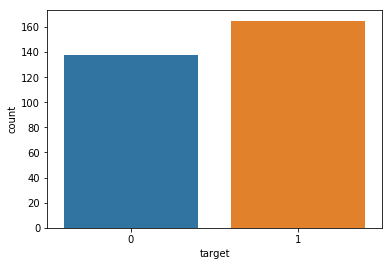

In [ ]:
sns.countplot(x='target', data=df)
plt.show()

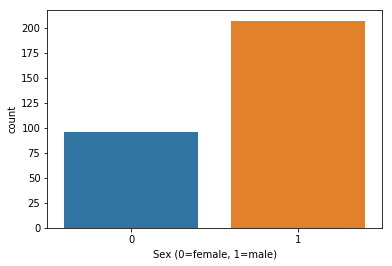

In [ ]:
sns.countplot(x='sex', data=df)
plt.xlabel('Sex (0=female, 1=male)')
plt.show()

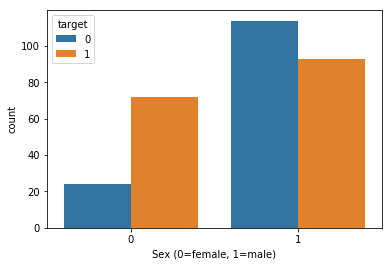

In [ ]:
sns.countplot(x='sex', hue='target', data=df)
plt.xlabel('Sex (0=female, 1=male)')
plt.show()

In [ ]:
percentFemale = len(df[df.sex==0])/len(df.sex)*100
percentMale = len(df[df.sex==1])/len(df.sex)*100
print(f'Percentage of Female Patients: {percentFemale:.2f}%')
print(f'Percentage of Male Patients: {percentMale:.2f}%')

Percentage of Female Patients: 31.68%
Percentage of Male Patients: 68.32%


In [ ]:
percentFemaleWithDisease = len(df[(df.sex==0) & (df.target==1)])/len(df[df.sex==0])*100
percentMaleWithDisease = len(df[(df.sex==1) & (df.target==1)])/len(df[df.sex==1])*100
print(f'Percentage of Female Patients with Disease: {percentFemaleWithDisease:.2f}%')
print(f'Percentage of Male Patients with Disease: {percentMaleWithDisease:.2f}%')

Percentage of Female Patients with Disease: 75.00%
Percentage of Male Patients with Disease: 44.93%


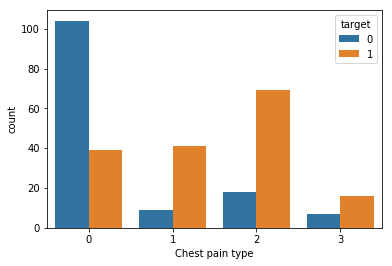

In [ ]:
sns.countplot(x='cp', hue='target', data=df)
plt.xlabel('Chest pain type')
plt.show()

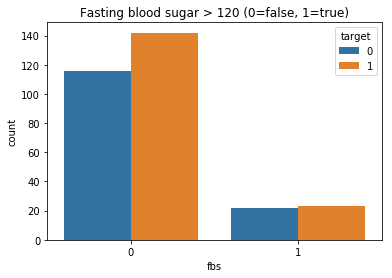

In [ ]:
sns.countplot(x='fbs', hue='target', data=df)
plt.title('Fasting blood sugar > 120 (0=false, 1=true)')
plt.show()

In [ ]:
df.groupby('target').mean()

age       sex        cp    ...        slope        ca      thal
target                                   ...                                 
0       56.601449  0.826087  0.478261    ...     1.166667  1.166667  2.543478
1       52.496970  0.563636  1.375758    ...     1.593939  0.363636  2.121212

[2 rows x 13 columns]

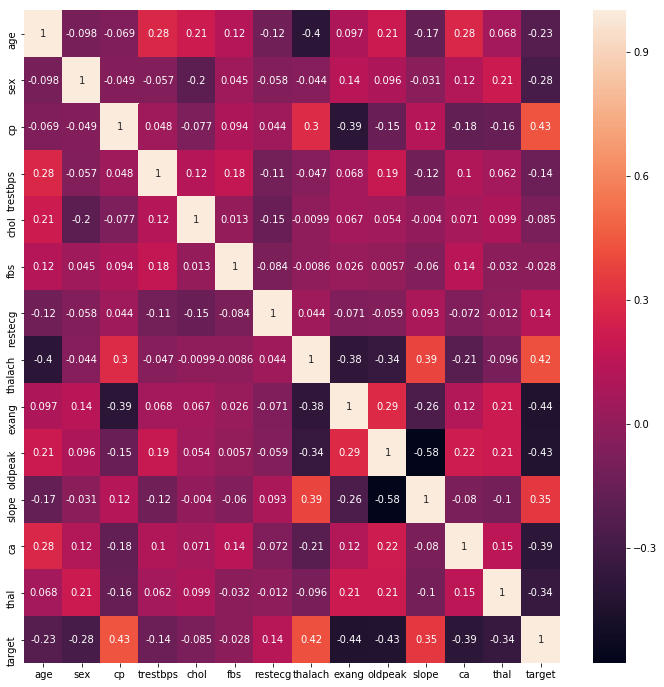

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, ax=ax)

## Creating categorical variables

In [ ]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [ ]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [ ]:
cat_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'thal']

In [ ]:
df_cat = df.astype(dict((item, 'object') for item in cat_columns))

In [ ]:
df_cat.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [ ]:
df_cat.head()

age sex cp  trestbps  chol fbs   ...   exang  oldpeak slope  ca  thal  target
0   63   1  3       145   233   1   ...       0      2.3     0   0     1       1
1   37   1  2       130   250   0   ...       0      3.5     0   0     2       1
2   41   0  1       130   204   0   ...       0      1.4     2   0     2       1
3   56   1  1       120   236   0   ...       0      0.8     2   0     2       1
4   57   0  0       120   354   0   ...       1      0.6     2   0     2       1

[5 rows x 14 columns]

In [ ]:
pd.__version__

'0.23.4'

In [ ]:
df_cat = pd.get_dummies(df_cat, columns=cat_columns)
df_cat.head()

age  trestbps  chol  thalach   ...    thal_0  thal_1  thal_2  thal_3
0   63       145   233      150   ...         0       1       0       0
1   37       130   250      187   ...         0       0       1       0
2   41       130   204      172   ...         0       0       1       0
3   56       120   236      178   ...         0       0       1       0
4   57       120   354      163   ...         0       0       1       0

[5 rows x 25 columns]

## Trying models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb

In [ ]:
train = np.array(df.drop('target', axis=1))
y_train = np.array(df['target'])

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def get_cv_scores(model, print_scores=True):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    accuracy = cross_val_score(model, train, y_train, scoring="accuracy", cv = kf)
    f1_score = cross_val_score(model, train, y_train, scoring="f1", cv = kf)
    roc_auc_score = cross_val_score(model, train, y_train, scoring="roc_auc", cv = kf)
    if print_scores:
        print(f'Accuracy: {accuracy.mean():.3f} ({accuracy.std():.3f})')
        print(f'f1_score: {f1_score.mean():.3f} ({f1_score.std():.3f})')
        print(f'roc_auc_score: {roc_auc_score.mean():.3f} ({roc_auc_score.std():.3f})')
    return [accuracy, f1_score, roc_auc_score]

In [ ]:
%%time
lr = LogisticRegression()
get_cv_scores(lr);

Accuracy: 0.822 (0.055)
f1_score: 0.843 (0.043)
roc_auc_score: 0.901 (0.038)
CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 100 ms


In [ ]:
%%time
svm = SVC()
get_cv_scores(svm);

Accuracy: 0.545 (0.004)
f1_score: 0.705 (0.004)
roc_auc_score: 0.583 (0.099)
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 104 ms


In [ ]:
%%time
rf = RandomForestClassifier()
get_cv_scores(rf);

Accuracy: 0.782 (0.045)
f1_score: 0.767 (0.041)
roc_auc_score: 0.876 (0.031)
CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 179 ms


In [ ]:
%%time
gb = GradientBoostingClassifier()
get_cv_scores(gb);

Accuracy: 0.815 (0.033)
f1_score: 0.835 (0.028)
roc_auc_score: 0.887 (0.034)
CPU times: user 888 ms, sys: 0 ns, total: 888 ms
Wall time: 886 ms


In [ ]:
%%time
et = ExtraTreesClassifier()
get_cv_scores(et);

Accuracy: 0.819 (0.047)
f1_score: 0.811 (0.038)
roc_auc_score: 0.876 (0.035)
CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 166 ms


In [ ]:
%%time
xgb_model = xgb.XGBClassifier()
get_cv_scores(xgb_model);

Accuracy: 0.805 (0.039)
f1_score: 0.825 (0.035)
roc_auc_score: 0.883 (0.039)
CPU times: user 492 ms, sys: 156 ms, total: 648 ms
Wall time: 651 ms


In [ ]:
%%time
lgb_model = lgb.LGBMClassifier()
get_cv_scores(lgb_model);

Accuracy: 0.808 (0.031)
f1_score: 0.828 (0.029)
roc_auc_score: 0.884 (0.036)
CPU times: user 316 ms, sys: 344 ms, total: 660 ms
Wall time: 663 ms


## Trying model on categorical dataframe

In [ ]:
train = np.array(df_cat.drop('target', axis=1))
y_train = np.array(df_cat['target'])

In [ ]:
%%time
lr = LogisticRegression()
get_cv_scores(lr);

Accuracy: 0.812 (0.039)
f1_score: 0.836 (0.031)
roc_auc_score: 0.907 (0.031)
CPU times: user 48 ms, sys: 8 ms, total: 56 ms
Wall time: 54.7 ms


In [ ]:
%%time
xgb_model = xgb.XGBClassifier()
get_cv_scores(xgb_model);

Accuracy: 0.802 (0.046)
f1_score: 0.819 (0.040)
roc_auc_score: 0.889 (0.040)
CPU times: user 684 ms, sys: 116 ms, total: 800 ms
Wall time: 795 ms


In [ ]:
%%time
lgb_model = lgb.LGBMClassifier()
get_cv_scores(lgb_model);

Accuracy: 0.809 (0.025)
f1_score: 0.829 (0.029)
roc_auc_score: 0.877 (0.033)
CPU times: user 352 ms, sys: 228 ms, total: 580 ms
Wall time: 581 ms


## Tuning Parameters

In [ ]:
train = np.array(df.drop('target', axis=1))
y_train = np.array(df['target'])

### Tune LogisticRegression

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

params = {
    'C': [0.1, 0.3, 1, 3],
    'max_iter': [50, 100, 200],
}

clf = RandomizedSearchCV(LogisticRegression(), params, cv=5, scoring='accuracy', random_state=1)
clf.fit(train, y_train)
print(clf.best_params_)

{'max_iter': 50, 'C': 0.3}
CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 160 ms


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
%%time
lg_tuned = LogisticRegression(**clf.best_params_)
get_cv_scores(lg_tuned)

Accuracy: 0.845 (0.054)
f1_score: 0.867 (0.041)
roc_auc_score: 0.902 (0.039)
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 50.1 ms


### Tune XGBoost

In [ ]:
%%time

params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 800, 1100],
    'colsample_bytree': [0.5, 0.8, 1],
    'subsample': [0.5, 0.8, 1]
}

clf = RandomizedSearchCV(xgb.XGBClassifier(), params, cv=5, scoring='roc_auc', random_state=1)
clf.fit(train, y_train)
print(clf.best_params_)

{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 5, 'colsample_bytree': 0.8}
CPU times: user 8.43 s, sys: 2.5 s, total: 10.9 s
Wall time: 10.9 s


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
%%time
xgb_model_tuned = xgb.XGBClassifier(**clf.best_params_)
get_cv_scores(xgb_model_tuned)

Accuracy: 0.822 (0.042)
f1_score: 0.840 (0.035)
roc_auc_score: 0.898 (0.025)
CPU times: user 564 ms, sys: 192 ms, total: 756 ms
Wall time: 751 ms


### Tune LightGBM

In [ ]:
%%time
params = {
    'max_depth': [3, 5, 7, -1],
    'n_estimators': [50, 100, 300, 800, 1100],
    'colsample_bytree': [0.5, 0.8, 1],
}

clf = RandomizedSearchCV(lgb.LGBMClassifier(), params, cv=5, scoring='roc_auc', random_state=1)
clf.fit(train, y_train)
print(clf.best_params_)

{'n_estimators': 50, 'max_depth': 3, 'colsample_bytree': 1}
CPU times: user 4.24 s, sys: 3.81 s, total: 8.05 s
Wall time: 8.05 s


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
%%time
lgb_model_tuned = xgb.XGBClassifier(**clf.best_params_)
get_cv_scores(lgb_model_tuned)

Accuracy: 0.825 (0.034)
f1_score: 0.845 (0.027)
roc_auc_score: 0.900 (0.033)
CPU times: user 308 ms, sys: 60 ms, total: 368 ms
Wall time: 365 ms


## Stacking Models

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin

# based on https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
class StackingAveragedModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        """Fit all the models on the given dataset"""
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        # Train cloned base models and create out-of-fold predictions
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Train meta-model on out-of-fold predicitions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

    def predict_proba(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict_proba(meta_features)

In [ ]:
%%time
stacked_averaged_model_1 = StackingAveragedModels(base_models=[GradientBoostingClassifier(), xgb.XGBClassifier(),
                                                               lgb.LGBMClassifier(),LogisticRegression()], meta_model=LogisticRegression())
stacked_averaged_model_1.fit(train, y_train)
get_cv_scores(stacked_averaged_model_1);

Accuracy: 0.828 (0.045)
f1_score: 0.847 (0.030)
roc_auc_score: 0.884 (0.051)
CPU times: user 8.69 s, sys: 2 s, total: 10.7 s
Wall time: 10.7 s


In [ ]:
%%time
stacked_averaged_model_2 = StackingAveragedModels(base_models=[xgb_model_tuned, lgb_model_tuned],
                                                  meta_model=LogisticRegression())
stacked_averaged_model_2.fit(train, y_train)
get_cv_scores(stacked_averaged_model_1);

Accuracy: 0.825 (0.044)
f1_score: 0.850 (0.031)
roc_auc_score: 0.880 (0.055)
CPU times: user 8.25 s, sys: 2.06 s, total: 10.3 s
Wall time: 10.3 s


## Interpreting models

### Feature importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

def get_feature_importance(model, X, y, feature_names):
    perm = PermutationImportance(model, random_state=42).fit(X, y)
    return eli5.show_weights(perm, feature_names=feature_names)

In [ ]:
from sklearn.model_selection import train_test_split

train = np.array(df.drop('target', axis=1))
y_train = np.array(df['target'])

X_train, X_test, y_train, y_test = train_test_split(train ,y_train , test_size=0.2, random_state=1)

In [ ]:
feature_names = df.drop('target', axis=1).columns.tolist()

#### LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=50, C=0.3).fit(X_train, y_train)
get_feature_importance(lr, X_test, y_test, feature_names)

#### XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, colsample_bytree=0.8, subsample=0.5).fit(X_train, y_train)
get_feature_importance(xgb_model, X_test, y_test, feature_names)

#### LightGBM

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=50, max_depth=3, colsample_bytree=1).fit(X_train, y_train)
get_feature_importance(lgb_model, X_test, y_test, feature_names)

### Partial Dependence Plots

In [ ]:
!pip install git+https://github.com/SauceCat/PDPbox.git

  Cloning https://github.com/SauceCat/PDPbox.git to /tmp/pip-req-build-ag6e4v9m
  Stored in directory: /tmp/pip-ephem-wheel-cache-pby3z314/wheels/39/f0/89/14e25f3f68e3edab29021bb801571827b0c600c826661a315a
Successfully built PDPbox
  Found existing installation: PDPbox 0.2.0
    Uninstalling PDPbox-0.2.0:
      Successfully uninstalled PDPbox-0.2.0


In [ ]:
from pdpbox import pdp, get_dataset, info_plots

from sklearn.model_selection import train_test_split

train = df.drop('target', axis=1)
y_train = df['target']

X_train, X_test, y_train, y_test = train_test_split(train ,y_train , test_size=0.2, random_state=1)

#### Sex

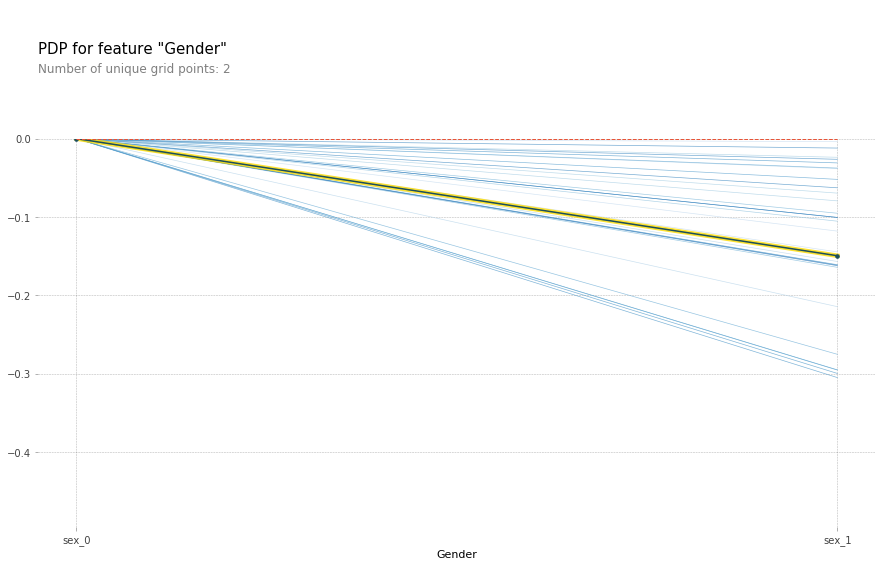

In [ ]:
pdp_sex = pdp.pdp_isolate(model=lr, dataset=X_test, model_features=feature_names, feature='sex')

pdp.pdp_plot(pdp_sex, 'Gender', plot_lines=True, frac_to_plot=0.5)
plt.show()

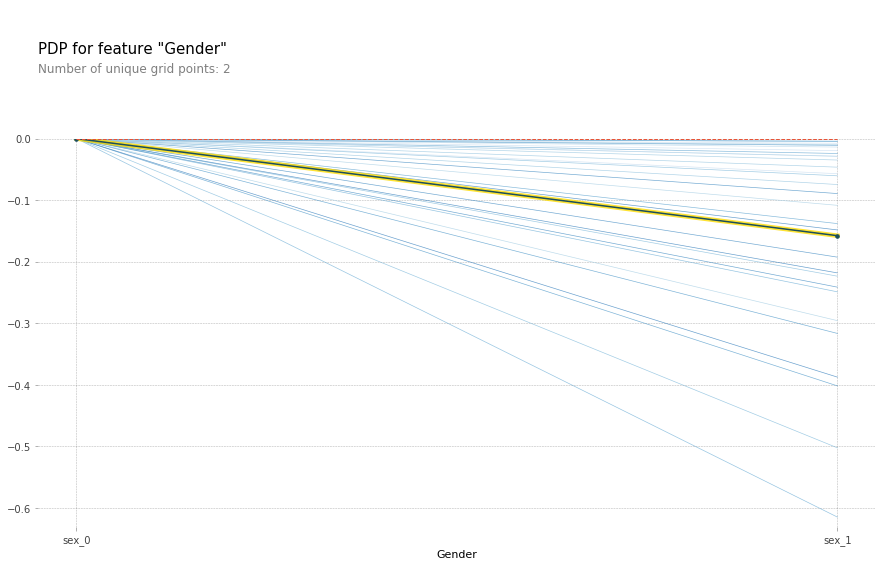

In [ ]:
pdp_sex = pdp.pdp_isolate(model=lgb_model, dataset=X_test, model_features=feature_names, feature='sex')

pdp.pdp_plot(pdp_sex, 'Gender', plot_lines=True, frac_to_plot=0.5)
plt.show()

#### thal

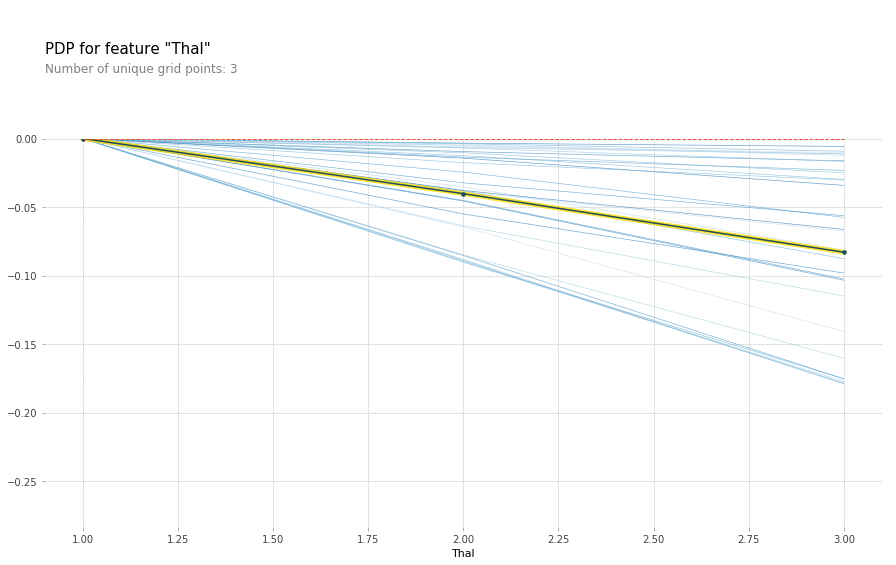

In [ ]:
pdp_thal = pdp.pdp_isolate(model=lr, dataset=X_test, model_features=feature_names, feature='thal')

pdp.pdp_plot(pdp_thal, 'Thal', plot_lines=True, frac_to_plot=0.5)
plt.show()

#### ca

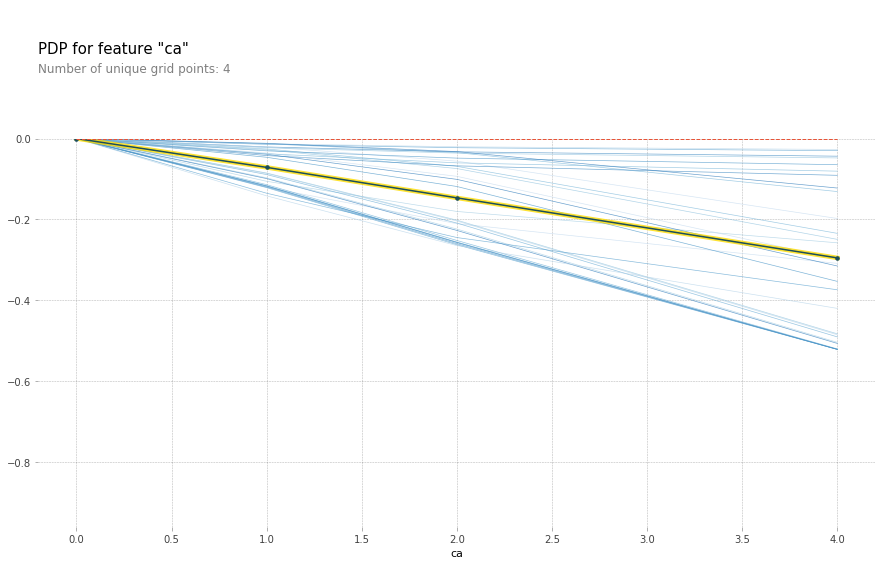

In [ ]:
pdp_thal = pdp.pdp_isolate(model=lr, dataset=X_test, model_features=feature_names, feature='ca')

pdp.pdp_plot(pdp_thal, 'ca', plot_lines=True, frac_to_plot=0.5)
plt.show()

### 2d Partial Dependence Plots

#### Age + Gender

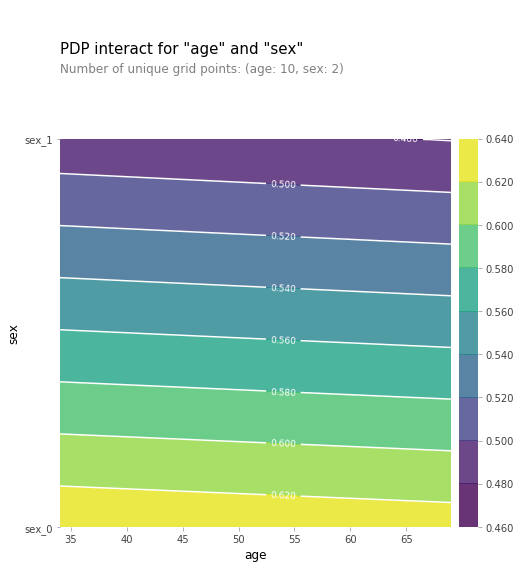

In [ ]:
features_to_plot = ['age', 'sex']
inter1 = pdp.pdp_interact(model=lr, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

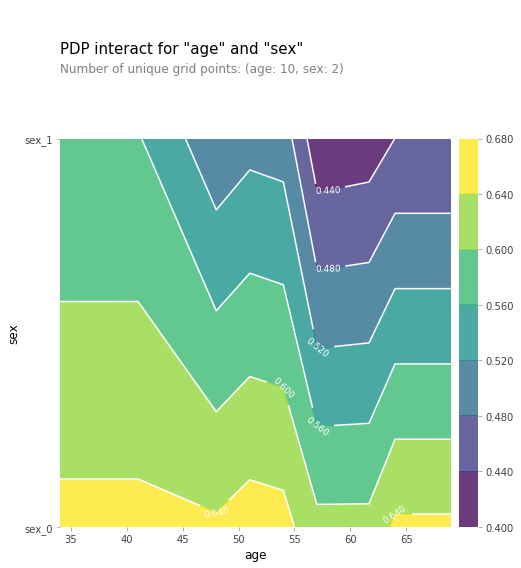

In [ ]:
features_to_plot = ['age', 'sex']
inter1 = pdp.pdp_interact(model=lgb_model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

#### CA + Gender

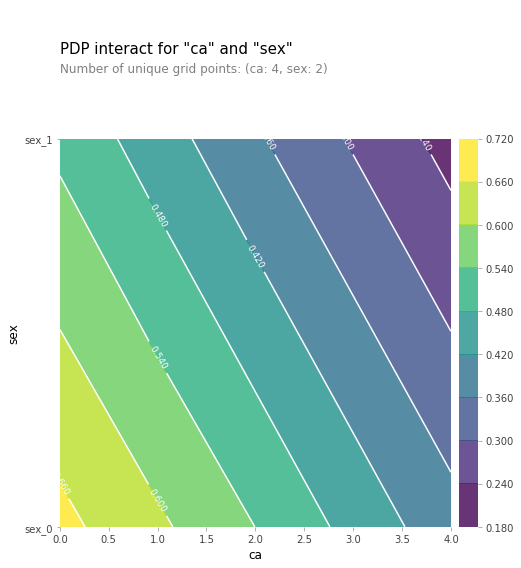

In [ ]:
features_to_plot = ['ca', 'sex']
inter1 = pdp.pdp_interact(model=lr, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

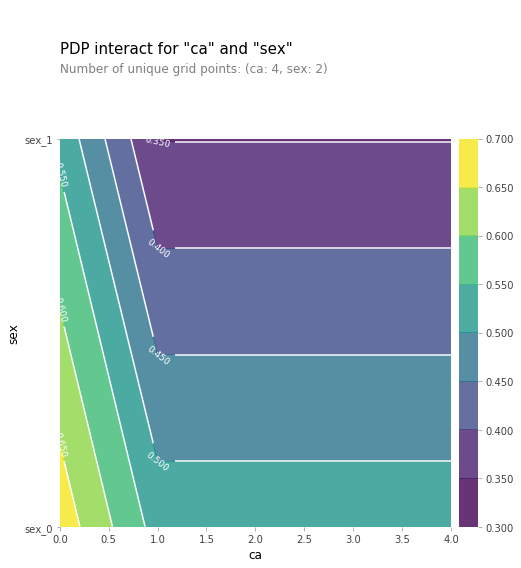

In [ ]:
features_to_plot = ['ca', 'sex']
inter1 = pdp.pdp_interact(model=lgb_model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

### Shap Values

In [ ]:
X_test.iloc[0:5]

age  sex  cp  trestbps  chol  ...   exang  oldpeak  slope  ca  thal
204   62    0   0       160   164  ...       0      6.2      0   3     3
159   56    1   1       130   221  ...       0      0.0      2   0     3
219   48    1   0       130   256  ...       1      0.0      2   2     3
174   60    1   0       130   206  ...       1      2.4      1   2     3
184   50    1   0       150   243  ...       0      2.6      1   0     3

[5 rows x 13 columns]

In [ ]:
y_test.iloc[0:5]

204    0
159    1
219    0
174    0
184    0
Name: target, dtype: int64

In [ ]:
lr.predict_proba(np.array(X_test.iloc[0:5]))

array([[0.9945355 , 0.0054645 ],
       [0.23743512, 0.76256488],
       [0.88217731, 0.11782269],
       [0.98415235, 0.01584765],
       [0.95373774, 0.04626226]])

In [ ]:
lgb_model.predict_proba(np.array(X_test.iloc[0:5]))

array([[0.98921945, 0.01078055],
       [0.08790518, 0.91209482],
       [0.92025903, 0.07974097],
       [0.98763946, 0.01236054],
       [0.87122544, 0.12877456]])

#### LightGBM Model

In [ ]:
import shap

# Create a object that can calculate shap values for our logistic regression model
explainer = shap.TreeExplainer(lgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(np.array(X_test))

In [ ]:
shap_values[:,0]

array([-0.35643876, -0.17227392,  0.1299177 , -0.38166683,  0.08749846,
       -0.31665157, -0.12180418,  0.04763635, -0.39668771,  0.41120301,
       -0.16657391, -0.29509319, -0.58486888, -0.39637491,  0.00508897,
       -0.58457576,  0.85852068, -0.26126952,  0.21228079, -0.69092965,
        0.02506202,  0.100896  ,  0.09023603,  0.57370564,  0.49155252,
        0.94971589, -0.38166683,  0.90850698,  0.02850503,  0.1355342 ,
        0.85852068,  0.06025143,  0.09662619, -0.47561413,  0.07411912,
        0.12030739, -0.02244272, -0.04417783,  0.25578589,  0.0542216 ,
       -0.42299727, -0.38166683, -0.2352264 , -0.27440675, -0.12377239,
       -0.33260483, -0.22211009, -0.32917369,  0.28314214, -0.19309056,
        0.05811363,  0.17037104,  0.75251542, -0.23248559, -0.48286901,
        0.1346633 , -0.53194467, -0.37768195,  0.81352274, -0.49568087,
       -0.08409402])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

### Partial Dependence Plots with Shap

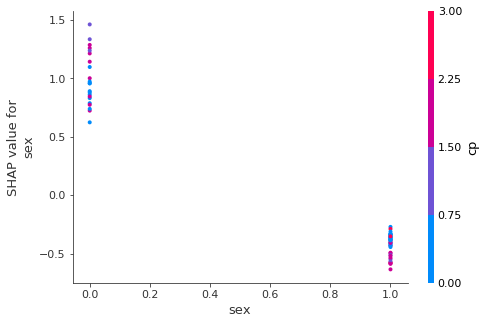

In [ ]:
shap.dependence_plot('sex', shap_values, X_test)

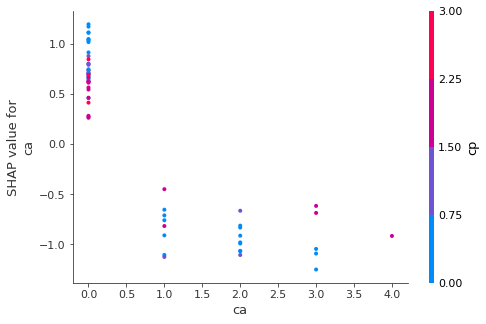

In [ ]:
shap.dependence_plot('ca', shap_values, X_test)

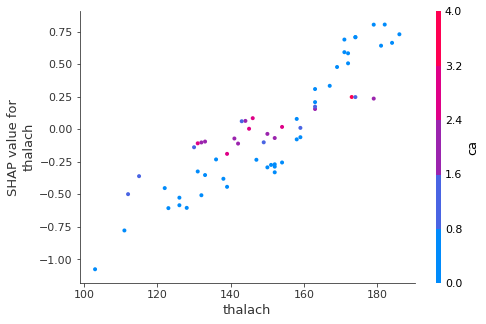

In [ ]:
shap.dependence_plot('thalach', shap_values, X_test)

### Summary plot (simular to feature importance but more information)


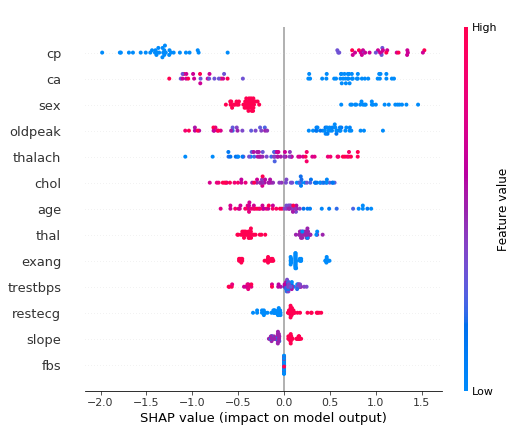

In [ ]:
shap.summary_plot(shap_values, X_test)

## Conclusion
This dataset is pretty small for today's standards but is still gives us a pretty good look at different features that cause heart diseases.

This notebook isn't complete and I will try to approve it in the upcoming weeks. If you have any recommendations please leave a comment down below.